In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.segmentation import slic
import plotly.graph_objects as go

In [ ]:
paths = ['h1849462/h&e_ROI_3.tif', 'h1849462/melan a_ROI_1.tif', 'h1849462/sox10_ROI_1.tif']

## Part 1: Epithelium

In [ ]:
# HELPER FUNCTIONS (extract epithelium)
def generate_epithelium_mask(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)

    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)

    # Draw a red outline
    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 8)  # Draw red contours

    return contour_mask, contours, image

def create_and_cut_superpixels(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate and display superpixels
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    segmented_image = np.zeros_like(image_rgb)
    lower_purple = np.array([125, 40, 40])
    upper_purple = np.array([155, 255, 255])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)

        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]
            inside_hsv = cv2.cvtColor(inside_segment, cv2.COLOR_RGB2HSV)
            purple_inside_mask = cv2.inRange(inside_hsv, lower_purple, upper_purple)

            # Calculate purple concentration inside
            total_pixels_inside = np.sum(inside_segment[:, :, 0] > 0)
            purple_pixels_inside = np.sum(purple_inside_mask > 0)
            purple_concentration_inside = purple_pixels_inside / total_pixels_inside if total_pixels_inside > 0 else 0

            # Assign colors based on purple concentration for inside
            if purple_concentration_inside > 0.15:
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif purple_concentration_inside > 0.015:
                segmented_image[inside_mask] = [255, 255, 255]
            else:
                segmented_image[inside_mask] = [0, 0, 0]

        # Process outside region (background)
        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]  # Assign black to outside background

    # Display the final segmented image with contour overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image with Contour-Based Cuts")
    plt.axis('off')
    plt.show()

    return segmented_image

# Combining Team 6's code with Team 2's code
def combined_contour_superpixel_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = create_and_cut_superpixels(original_image, contour_mask, contours)
    return segmented_image

# HELPER FUNCTIONS (get coordinates)
def create_mask_from_segmented_image(segmented_image):
    # Convert segmented image to grayscale if it's not already
    gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask (white regions for segmented areas)
    _, binary_mask = cv2.threshold(gray_segmented, 1, 255, cv2.THRESH_BINARY)

    # Optionally, apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    return cleaned_mask

def get_coordinates_from_mask(mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to store coordinates of the contours
    coordinates_list = []

    for contour in contours:
        # Flatten each contour's points and convert to tuples of native Python integers
        contour_points = contour.reshape(-1, 2)  # Reshape to (N, 2) where N is the number of points
        # Convert np.int32 to regular Python int and create a tuple (x, y)
        coordinates_list.append([tuple([int(point[0]), int(point[1])]) for point in contour_points])

    coordinates_list = [point for sublist in coordinates_list for point in sublist]

    return coordinates_list

In [ ]:
he_ep = combined_contour_superpixel_segmentation('h1849462/h&e_ROI_3.tif')

### Epithelium pipeline

In [ ]:
def pipeline_epithelium(image_path, num_patches):
    ep = combined_contour_superpixel_segmentation(image_path)
    mask = create_mask_from_segmented_image(ep)
    coord_all = get_coordinates_from_mask(mask)

    # Calculate the step size for every n-th coordinate
    step_size = len(coord_all) // num_patches
    # Select every n-th coordinate based on the step size
    subset = coord_all[::step_size]  # This slices the list to get every step_size-th element
    # If the length of the subset is larger than desired_count, truncate the list
    coord_subset = subset[:num_patches]

    return coord_all, coord_subset

In [ ]:
coord_all, coord_subset = pipeline_epithelium('h1849462/h&e_ROI_3.tif', 5)

## Part 2: Transformation

In [3]:
# Calculate overlap score
def calculate_overlap(mask1, mask2):
    intersection = cv2.bitwise_and(mask1, mask2)
    union = cv2.bitwise_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    # Check the number of dimensions in the image
    if len(image.shape) == 2:
        # Grayscale image (2D)
        h, w = image.shape
    elif len(image.shape) == 3:
        # Color image (3D)
        h, w, c = image.shape  # c is the number of channels (e.g., 3 for RGB)
    else:
        raise ValueError("Unsupported image dimensions")

    # Calculate padding
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left

    # Apply padding
    if len(image.shape) == 2:
        # Grayscale image padding (2D)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    elif len(image.shape) == 3:
        # Color image padding (3D)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)

    return padded_image

# HELPER FUNCTIONS (masking)
# Clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Combines functions above
def mask(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

# HELPER FUNCTIONS (translation)
# Rotate image
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Flip image horizontally or vertically
def flip_image(image, flip_type):
    if flip_type == 'horizontal':
        return cv2.flip(image, 1)
    elif flip_type == 'vertical':
        return cv2.flip(image, 0)
    else:
        return image

# Translate image by (tx, ty) pixels
def translate_image(image, tx, ty):
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

### Transformation pipeline

In [4]:
def pipeline_transformation(path1, path2, path3):
    # Load the masks
    mask1 = mask(path1)
    mask2 = mask(path2)
    mask3 = mask(path3)

    # Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Calculate the original similarity scores for mask2 and mask3
    original_similarity_2 = calculate_overlap(mask1, mask2)
    original_similarity_3 = calculate_overlap(mask1, mask3)

    # Initialize variables
    best_similarity_2 = original_similarity_2
    best_similarity_3 = original_similarity_3
    best_mask2 = mask2
    best_mask3 = mask3
    best_transformation_2 = (0, None, 0, 0)
    best_transformation_3 = (0, None, 0, 0)
    max_tx = int(0.02 * max_width)  # ±2% of width 
    max_ty = int(0.02 * max_height)  # ±2% of height

    # Step 4: Test flips and rotations before applying translations
    for flip in [None, 'horizontal', 'vertical']:  # Flip types
        for angle in range(0, 360, 15):  # Rotation angles from 0° to 360° in 15° intervals
            # Apply the rotation to both masks
            rotated_mask2 = rotate_image(mask2, angle)
            rotated_mask3 = rotate_image(mask3, angle)

            # Apply flip (if any)
            if flip == 'horizontal':
                rotated_mask2 = cv2.flip(rotated_mask2, 1)  # Flip horizontally
                rotated_mask3 = cv2.flip(rotated_mask3, 1)  # Flip horizontally
            elif flip == 'vertical':
                rotated_mask2 = cv2.flip(rotated_mask2, 0)  # Flip vertically
                rotated_mask3 = cv2.flip(rotated_mask3, 0)  # Flip vertically

            # Track the similarity after each transformation step
            current_similarity_2 = calculate_overlap(mask1, rotated_mask2)
            current_similarity_3 = calculate_overlap(mask1, rotated_mask3)

            # Only update masks and transformations if the similarity improves
            if current_similarity_2 > best_similarity_2:
                best_similarity_2 = current_similarity_2
                best_transformation_2 = (angle, flip, 0, 0)  # Rotation and flip only
                best_mask2 = rotated_mask2

            if current_similarity_3 > best_similarity_3:
                best_similarity_3 = current_similarity_3
                best_transformation_3 = (angle, flip, 0, 0)  # Rotation and flip only
                best_mask3 = rotated_mask3

            # Now, apply translations (with a finer step size, e.g., 50 pixels)
            for tx in range(-max_tx, max_tx + 1, 50):  # Translation in x, 50-pixel step
                for ty in range(-max_ty, max_ty + 1, 50):  # Translation in y, 50-pixel step
                    # Apply translation to the best current transformations
                    translated_mask2 = translate_image(best_mask2, tx, ty)
                    translated_mask3 = translate_image(best_mask3, tx, ty)

                    # Calculate similarity score between mask1 and the transformed masks
                    similarity_score_2 = calculate_overlap(mask1, translated_mask2)
                    similarity_score_3 = calculate_overlap(mask1, translated_mask3)

                    # Only apply the translation if the similarity score improves
                    if similarity_score_2 > best_similarity_2:
                        best_similarity_2 = similarity_score_2
                        best_transformation_2 = (best_transformation_2[0], best_transformation_2[1], tx, ty)
                        best_mask2 = translated_mask2

                    if similarity_score_3 > best_similarity_3:
                        best_similarity_3 = similarity_score_3
                        best_transformation_3 = (best_transformation_3[0], best_transformation_3[1], tx, ty)
                        best_mask3 = translated_mask3

    results_dict = {
        'startsim2': original_similarity_2,
        'startsim3': original_similarity_3,
        'endsim2': best_similarity_2,
        'endsim3': best_similarity_3,
        'trans2': best_transformation_2,
        'trans3': best_transformation_3
    }

    # Step 5: Return the results (best transformation and final masks)
    print(f"mask1 and mask2 similarity:")
    print(f"Start: {original_similarity_2:.4f}")
    print(f"End: {best_similarity_2:.4f}")

    print(f"\nmask1 and mask3 similarity:")
    print(f"Startl: {original_similarity_3:.4f}")
    print(f"Endl: {best_similarity_3:.4f}")

    return mask1, mask2, mask3, best_mask2, best_mask3, results_dict

In [5]:
he, melana, sox, m_optimal, s_optimal, results_dict = pipeline_transformation(paths[0], paths[1], paths[2])

mask1 and mask2 similarity:
Start: 0.4818
End: 0.6656

mask1 and mask3 similarity:
Startl: 0.0369
Endl: 0.0454


## Part 3: Patching

In [378]:
# HELPER FUNCTIONS (transform tifs)
def rotate_image2(image, angle):
    # Get the dimensions of the image
    h, w = image.shape[:2]

    # Calculate the center of the image
    center = (w // 2, h // 2)

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the new dimensions of the rotated image (to avoid cropping)
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)

    # Adjust the rotation matrix to account for translation (to keep the image centered)
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated_image

def transform_image(path, transformation):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    angle2, flip2, tx2, ty2 = transformation

    transformed_image = rotate_image2(image, angle2)  # Rotate
    transformed_image = flip_image(transformed_image, flip2)  # Flip
    transformed_image = translate_image(transformed_image, tx2, ty2)  # Translate

    return transformed_image

# HELPER FUNCTIONS (patching)
def image_center(image):
    h, w = image.shape[:2]  # Get the height and width of the image
    center_x = w // 2
    center_y = h // 2
    return center_x, center_y

def sort_coords_clockwise(coord_list, center_x, center_y):
    def angle_from_center(coord):
        x, y = coord
        angle = np.arctan2(y - center_y, x - center_x)

        # Normalize the angle to [0, 2*pi]
        if angle < 0:
            angle += 2 * np.pi
        return angle

    # Print the angles before sorting for debugging
    angles = [angle_from_center(coord) for coord in coord_list]
    print("Angles:", angles)

    # Sort coordinates based on the angles
    sorted_coords = sorted(coord_list, key=angle_from_center)

    return sorted_coords

def adjust_coords(coord_list, center_x, center_y):
    adjusted_coords = []

    for x, y in coord_list:
        # Adjust the x-coordinate: move it relative to the center
        new_x = x - center_x

        # Adjust the y-coordinate: flip the y-axis to match the image system
        new_y = center_y - y

        # Flip the adjusted y-coordinate across the x-axis
        flipped_y = -new_y

        # Store the adjusted and flipped coordinates
        adjusted_coords.append((new_x, flipped_y))

    return adjusted_coords

def generate_unique_colors(num_colors):
    # Initialize list to store colors
    colors = []

    # Define hue range [0, 179] for OpenCV (since OpenCV uses HSV with hue in this range)
    hue_step = 180 / num_colors  # Step size to evenly distribute hues (OpenCV's max hue is 179)

    for i in range(num_colors):
        # Calculate the hue for this color (from 0 for red to 179 for violet)
        hue = int(i * hue_step) % 180  # Wrap hue around 180 if necessary

        # Set saturation and value to maximum (full saturation and brightness)
        saturation = 255
        value = 255

        # Convert from HSV to BGR (OpenCV uses BGR by default)
        bgr_color = cv2.cvtColor(np.uint8([[[hue, saturation, value]]]), cv2.COLOR_HSV2BGR)

        # Convert BGR to RGB (as OpenCV uses BGR by default)
        rgb_color = tuple(int(c) for c in bgr_color[0][0])

        colors.append(rgb_color)

    return colors

def get_patches(image, coord_list, patch_size=200):
    center_x, center_y = image_center(image)  # Get the center of the image
    patches = []  # This will store the list of square cutouts

    image_copy = image.copy()  # Create a copy of the image to draw rectangles on (keeping the original intact)

    # Generate a unique color for each coordinate (e.g., using a hash function to ensure uniqueness)
    colors = generate_unique_colors(len(coord_list))

    # Loop through the coordinates and extract patches
    for i, coord in enumerate(coord_list):
        # Calculate the bottom-left and top-right corners of the square based on the center and offsets
        bottom_left = (center_x + coord[0] - patch_size // 2, center_y + coord[1] - patch_size // 2)
        top_right = (bottom_left[0] + patch_size, bottom_left[1] + patch_size)

        # Get the x1, y1, x2, y2 coordinates of the patch
        x1, y1 = bottom_left
        x2, y2 = top_right

        # Create a black square to hold the extracted patch
        patch = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)

        # Check if the coordinates are within bounds and extract the patch
        x1_clipped = max(x1, 0)  # Ensure x1 is within bounds
        y1_clipped = max(y1, 0)  # Ensure y1 is within bounds
        x2_clipped = min(x2, image.shape[1])  # Ensure x2 is within bounds
        y2_clipped = min(y2, image.shape[0])  # Ensure y2 is within bounds

        # Extract the part of the patch that is within bounds
        patch_slice = image[y1_clipped:y2_clipped, x1_clipped:x2_clipped]

        # Get the height and width of the extracted portion
        extracted_height = patch_slice.shape[0]
        extracted_width = patch_slice.shape[1]

        # Place the extracted part into the black patch
        patch[patch_size - extracted_height:, patch_size - extracted_width:] = patch_slice

        # Store the extracted patch (with black padding) in the list
        patches.append(patch)

        # Get the color for the current coordinate
        color = colors[i]  # Get the color assigned to this coordinate

        # Draw the rectangle outline on the copied image (for visualization)
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), color, thickness=15)

    return image_copy, patches

# HELPER FUNCTIONS (visualizations)
def display_tissues(image1, image2, image3, patient):
    fig = plt.figure(figsize=(15, 5))  # Adjust size as needed

    # Display image1
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first image
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title("H&E")  # Title for the first image
    plt.axis('off')  # Hide axes

    # Display image2
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second image
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title("Melana")  # Title for the second image
    plt.axis('off')  # Hide axes

    # Display image3
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third image
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title("Sox 10")  # Title for the third image
    plt.axis('off')  # Hide axes

    plt.suptitle(patient, fontsize=16, fontweight='bold')
    plt.tight_layout()  # Automatically adjust subplots to fit
    plt.show()

    return fig

def display_patches(patches_dict):
    # Create a figure with multiple subplots
    num_squares = len(patches_dict)
    fig, axes = plt.subplots(num_squares, 3, figsize=(6, 2 * num_squares))

    if num_squares == 1:  # To handle the case of just a single row
        axes = [axes]

    # Generate colors for borders using the number of rows
    colors = generate_unique_colors(num_squares)
    colors_rgb = [(color[0] / 255.0, color[1] / 255.0, color[2] / 255.0) for color in colors]

    # Iterate over each coordinate and corresponding squares (from image1, image2, and image3)
    for i, (coord, squares) in enumerate(patches_dict.items()):
        square1, square2, square3 = squares

        border_color = colors_rgb[i]

        axes[i][0].imshow(cv2.cvtColor(square1, cv2.COLOR_BGR2RGB))
        axes[i][0].axis('off')
        axes[i][0].add_patch(plt.Rectangle((0, 0), square1.shape[1], square1.shape[0], linewidth=2, edgecolor=border_color, facecolor='none'))

        axes[i][1].imshow(cv2.cvtColor(square2, cv2.COLOR_BGR2RGB))
        # axes[i][1].set_title(f"{coord}", fontsize=10)
        axes[i][1].axis('off')
        axes[i][1].add_patch(plt.Rectangle((0, 0), square2.shape[1], square2.shape[0], linewidth=2, edgecolor=border_color, facecolor='none'))

        axes[i][2].imshow(cv2.cvtColor(square3, cv2.COLOR_BGR2RGB))
        axes[i][2].axis('off')
        axes[i][2].add_patch(plt.Rectangle((0, 0), square3.shape[1], square3.shape[0], linewidth=2, edgecolor=border_color, facecolor='none'))

    plt.tight_layout()
    plt.show()

    return fig

### Patching pipeline

In [385]:
def pipeline_patches(paths_dict, results_dict, coord_list, patch_size=400):
    key = list(paths_dict.keys())[0]

    # Load the images
    image1 = cv2.imread(paths_dict[key][0], cv2.IMREAD_COLOR)
    image2 = transform_image(paths_dict[key][1], results_dict['trans2'])
    image3 = transform_image(paths_dict[key][2], results_dict['trans3'])

    # Adjust coordinates
    center_x, center_y = image_center(image1)
    coord_sorted = sort_coords_clockwise(coord_list, center_x, center_y)
    coord_adjusted = adjust_coords(coord_sorted, center_x, center_y)

    # Get patches using adjusted coordinates
    transformed1, squares1 = get_patches(image1, coord_adjusted, patch_size=patch_size)
    transformed2, squares2 = get_patches(image2, coord_adjusted, patch_size=patch_size)
    transformed3, squares3 = get_patches(image3, coord_adjusted, patch_size=patch_size)

    patches_dict = {}

    for i, coord in enumerate(coord_adjusted):
        # Each adjusted coordinate corresponds to a square in squares1, squares2, and squares3
        square1 = squares1[i]  # Square from image1
        square2 = squares2[i]  # Square from image2
        square3 = squares3[i]  # Square from image3

        # Store in the dictionary with the adjusted coordinate as the key and the tuple of squares as the value
        patches_dict[coord] = (square1, square2, square3)

    vis_tissues = display_tissues(transformed1, transformed2, transformed3, key)
    vis_patches = display_patches(patches_dict)

    return vis_tissues, vis_patches, patches_dict

## Test

In [386]:
paths_test = {}
paths_test['h1849462'] = paths
paths_test

{'h1849462': ['h1849462/h&e_ROI_3.tif',
  'h1849462/melan a_ROI_1.tif',
  'h1849462/sox10_ROI_1.tif']}

Angles: [np.float64(1.0870690276099237), np.float64(0.546649641181395), np.float64(3.9915020161223973), np.float64(3.055573206850437), np.float64(0.18317223855102552)]


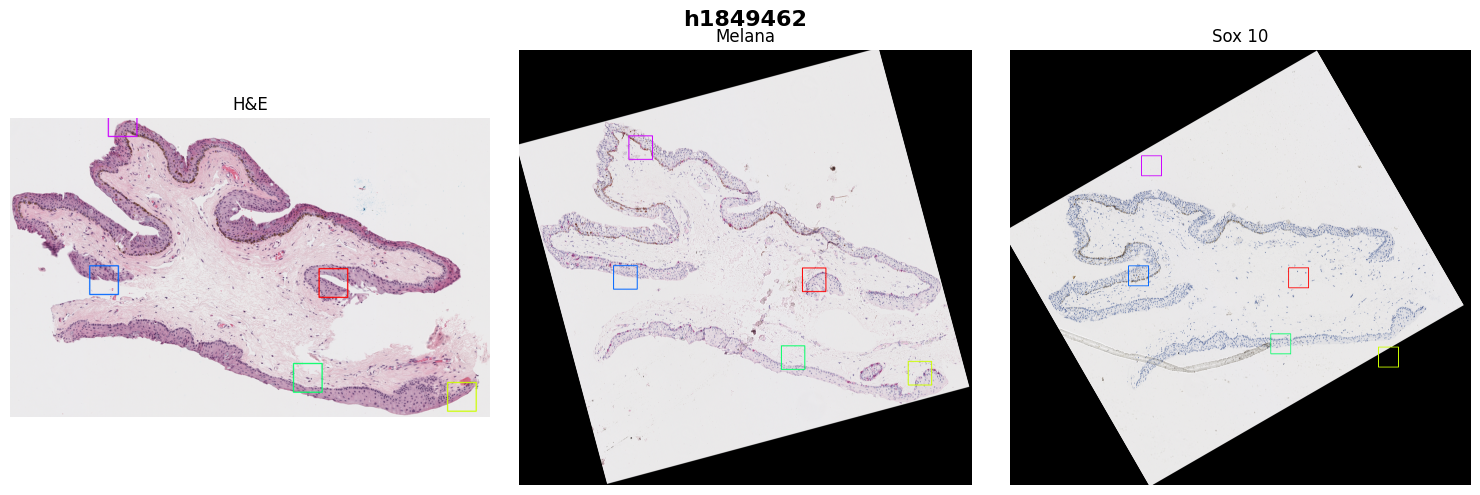

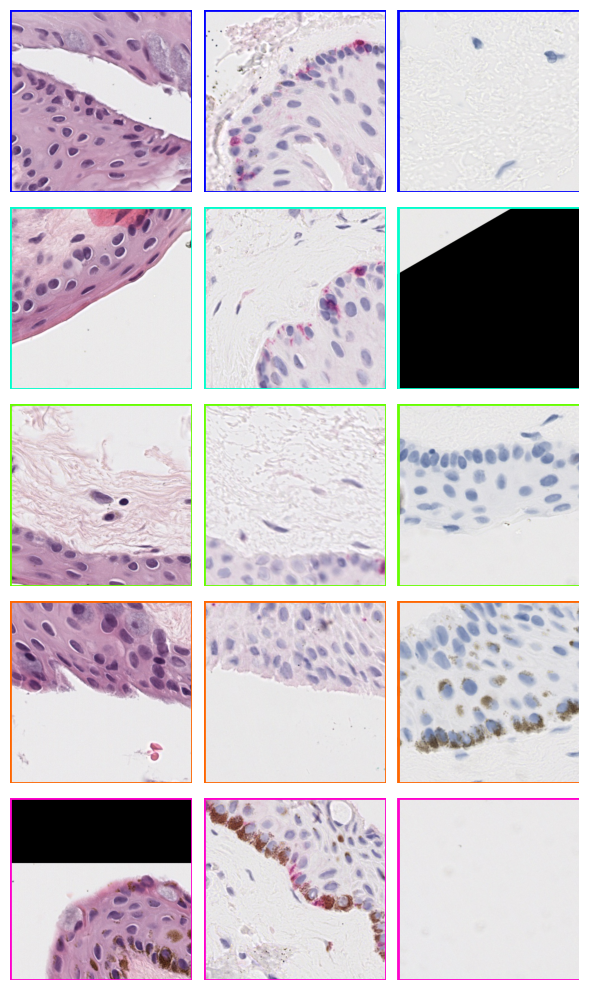

In [387]:
vis_tissues, vis_patches, patches_dict = pipeline_patches(paths_test, results_dict, coord_subset)

## Part 4: Automation

In [388]:
paths_test

{'h1849462': ['h1849462/h&e_ROI_3.tif',
  'h1849462/melan a_ROI_1.tif',
  'h1849462/sox10_ROI_1.tif']}

In [391]:
def pipeline(patients_dict, num_patches=10, patch_size=400):
    if not os.path.exists('patches'):
        os.makedirs('patches')

    for patient_key, patient_data in patients_dict.items():
        _, coord_subset = pipeline_epithelium(patient_data[0], num_patches=num_patches)
        _, _, _, _, _, results_dict = pipeline_transformation(patient_data[0], patient_data[1], patient_data[2])
        vis_tissues, vis_patches, patches_dict = pipeline_patches(patients_dict, results_dict, coord_subset, patch_size=patch_size)

        vis_tissues_filename = os.path.join('patches', f"{patient_key}.png")
        vis_tissues.savefig(vis_tissues_filename)

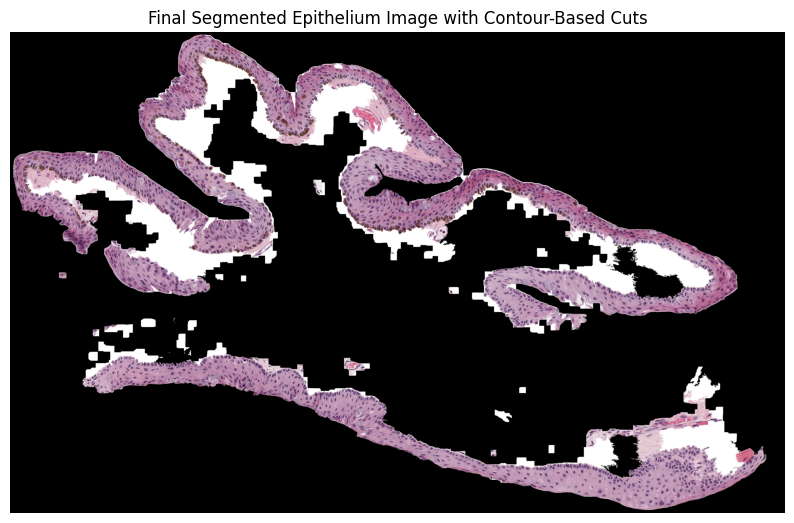

mask1 and mask2 similarity:
Start: 0.4818
End: 0.6656

mask1 and mask3 similarity:
Startl: 0.0369
Endl: 0.0454
Angles: [np.float64(1.0870690276099237), np.float64(0.546649641181395), np.float64(3.9915020161223973), np.float64(3.055573206850437), np.float64(0.18317223855102552)]


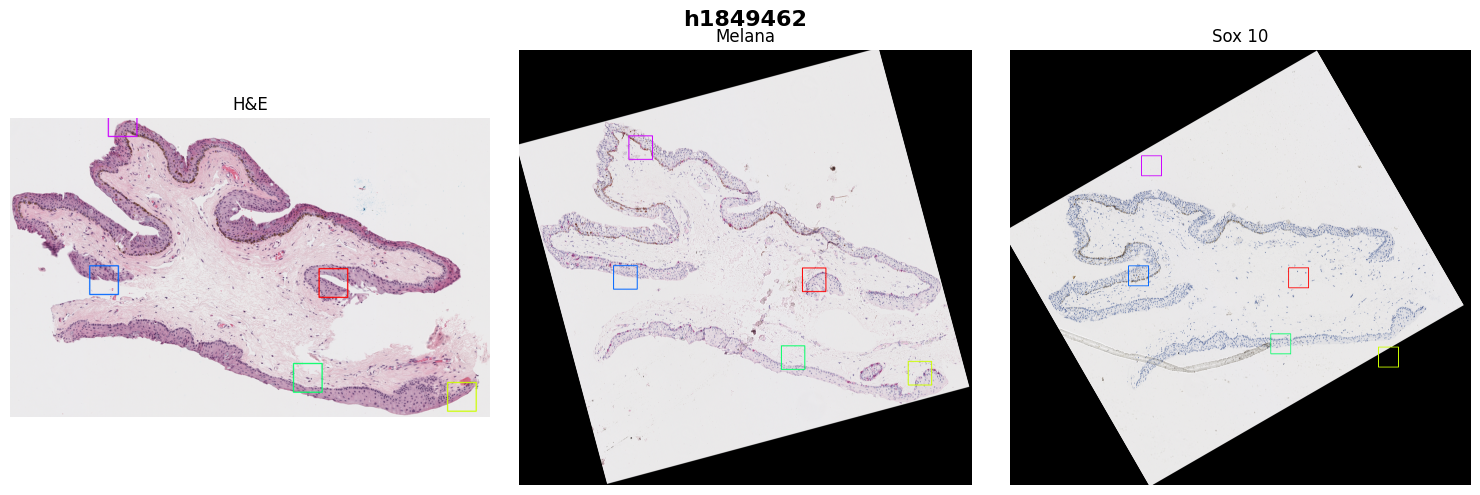

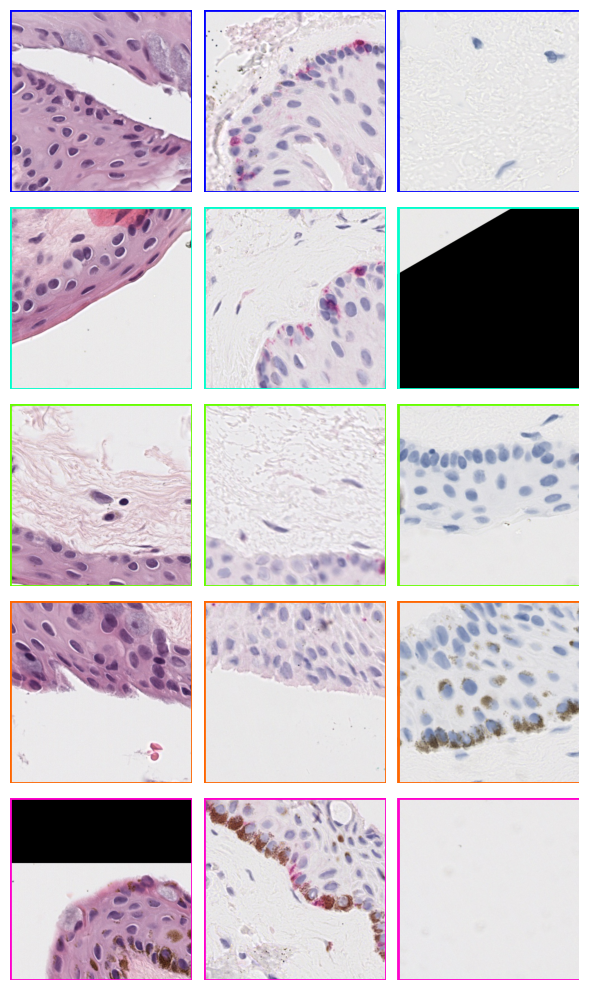

In [393]:
pipeline(paths_test, num_patches=5)